In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Applied Machine Learning Final Project - TOR Traffic Detection**


---
**Professor:**
Dr. Hitham Jleed


**Members:**
*   Mahsa Paknejad - `300349451`
*   Mehakdeep Kaur Dhothar - `300341033`

# DETECTION OF TOR TRAFFIC USING MACHINE LEARNING TECHINIQUES

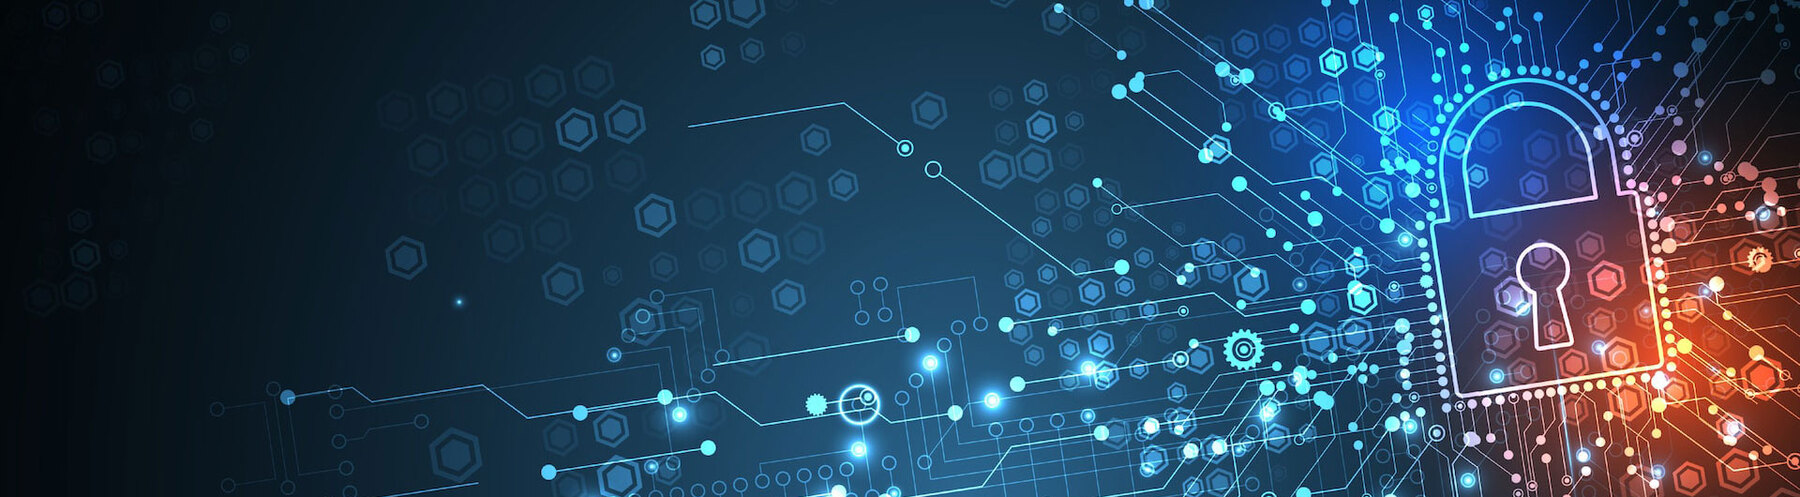

# Introduction

The **Tor (Onion Router) network** provides a safe place for Internet users to exchange data without revealing their identity and obfuscates the traffic which makes it difficult for potential observers or eavesdroppers to trace the user's online activities. While Tor software has enhanced online privacy for users, it has also paved a way for the criminals to engage in illicit activities while remaining anonymous, thereby posing significant challenges for law enforcement agencies in their efforts to trace and apprehend wrongdoers. Thus, **classifying Tor traffic from non-Tor traffic is critical to trace the Darknet users**. In addition, it can be effective in intrusion detection systems (IDS) and intrusion prevention systems (IPS) which rely on knowledge of normal network behavior to detect and prevent such attacks.

#### **Dataset Overview**
The UNB-CIC Tor Network Traffic Dataset has been amassed by the Information Security Center of Excellence (ISCX) at the University of New Brunswick in Canada in 2016. This dataset includes regular and Tor traffic recorded over a two-week timeframe and extracted from diverse network interfaces and devices, including laptops, smartphones, wired and wireless connections, and servers.

The following table briefly describes each feature of the dataset :-

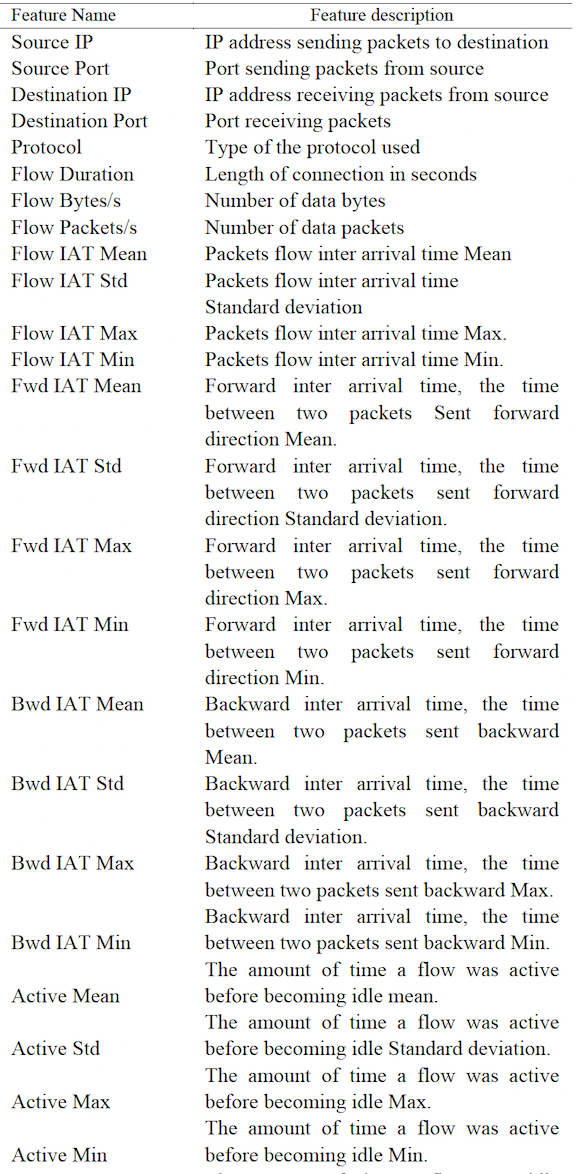

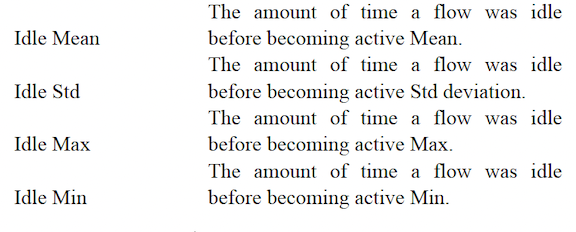

# Importing the libraries


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import train_test_split

from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE                # SMOTE
from imblearn.over_sampling import RandomOverSampler    # Oversampling
from imblearn.under_sampling import RandomUnderSampler  # Undersampling

from sklearn.model_selection import KFold               # K-fold cross validation

# Reading the dataset



In [ ]:
data = pd.read_csv("/content/drive/MyDrive/Applied ML/CSV/Scenario-A/SelectedFeatures-10s-TOR-NonTOR.csv")

In [ ]:
# Printing the dataset as a dataframe
data.head()

,Source IP,Source Port,Destination IP,Destination Port,Protocol,Flow Duration,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,...,Bwd IAT Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,label
0,10.0.2.15,53913,216.58.208.46,80,6,435,0.0,4597.701149,435.0,0.0,...,0,0,0,0,0,0,0,0,0,nonTOR
1,10.0.2.15,53913,216.58.208.46,80,6,259,0.0,7722.007722,259.0,0.0,...,0,0,0,0,0,0,0,0,0,nonTOR
2,10.0.2.15,53913,216.58.208.46,80,6,891,0.0,2244.668911,891.0,0.0,...,0,0,0,0,0,0,0,0,0,nonTOR
3,10.0.2.15,53913,216.58.208.46,80,6,1074,0.0,1862.197393,1074.0,0.0,...,0,0,0,0,0,0,0,0,0,nonTOR
4,10.0.2.15,53913,216.58.208.46,80,6,315,0.0,6349.206349,315.0,0.0,...,0,0,0,0,0,0,0,0,0,nonTOR



# Data Cleaning


In [ ]:
# Printing the size of the dataset
data.shape

(67834, 29)

We have 67834 data samples and 28 features + 1 column for the labels.

### Printing the names of all the features in the dataset




In [ ]:

# Get the row using iloc and then retrieve the column names
def features(data):
  column_names = data.columns
  targets = ['label']
  feature_names = [col for col in column_names if col not in targets]

  print("Feature names:")
  print(feature_names)
  counts = len(feature_names)
  print(f"\nThere are: {counts} features")
  return feature_names

feature_names = features(data)

Feature names:
['Source IP', ' Source Port', ' Destination IP', ' Destination Port', ' Protocol', ' Flow Duration', ' Flow Bytes/s', ' Flow Packets/s', ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Max', ' Flow IAT Min', 'Fwd IAT Mean', ' Fwd IAT Std', ' Fwd IAT Max', ' Fwd IAT Min', 'Bwd IAT Mean', ' Bwd IAT Std', ' Bwd IAT Max', ' Bwd IAT Min', 'Active Mean', ' Active Std', ' Active Max', ' Active Min', 'Idle Mean', ' Idle Std', ' Idle Max', ' Idle Min']

There are: 28 features


Therefore, the dataset has 67834 data samples and 28 features.

### Printing the unique labels in the dataset

In [ ]:
def labels(data):
  unique_labels = data.iloc[:, -1].unique()
  print(unique_labels)

labels(data)

['nonTOR' 'TOR']


### Replacing the infinite values (if any) with np.NaN values

In [ ]:
def replace_inf(data):
  data.replace([np.inf, -np.inf], np.nan, inplace=True)
  return data

data = replace_inf(data)

### Checking if there are any missing values in the dataset

In [ ]:
def check_missing(data):
  missing_flag = False
  for column in data.columns:
      missing_count = data[column].isnull().sum()
      if missing_count > 0:
          print(f"Feature '{column}' has {missing_count} missing values.")
          missing_flag = True

  if not missing_flag:
      print("No missing values in the whole dataset.")

check_missing(data)

Feature ' Flow Bytes/s' has 6 missing values.
Feature ' Flow Packets/s' has 6 missing values.


### Handling missing values
Since there are only six missing values in the Flow Bytes/s column, then it will be good to drop the rows with these missing values

In [ ]:
def missing_delete(data):
    data.dropna(inplace=True)
    return data

### Checking the columns with categorical data

In [ ]:
def convert_cat(data):
  categorical_columns = data.select_dtypes(exclude=['float64', 'int64']).columns

  if len(categorical_columns) > 0:
      print("The dataset has categorical columns.")
      print("Categorical columns:", list(categorical_columns))
  else:
      print("The dataset does not have any categorical columns.")

convert_cat(data)

The dataset has categorical columns.
Categorical columns: ['Source IP', ' Destination IP', 'label']


Converting columns with object datatype to float64 datatype.

In [ ]:
import hashlib
def conv_obj_float(data):
  data.loc[:,'Source IP'] = data.loc[:,'Source IP'].apply(hash).astype('float64')
  data.loc[:,' Destination IP'] = data.loc[:,' Destination IP'].apply(hash).astype('float64')
  return data

In [ ]:
data.dtypes

Source IP             object
 Source Port           int64
 Destination IP       object
 Destination Port      int64
 Protocol              int64
 Flow Duration         int64
 Flow Bytes/s        float64
 Flow Packets/s      float64
 Flow IAT Mean       float64
 Flow IAT Std        float64
 Flow IAT Max          int64
 Flow IAT Min          int64
Fwd IAT Mean         float64
 Fwd IAT Std         float64
 Fwd IAT Max           int64
 Fwd IAT Min           int64
Bwd IAT Mean         float64
 Bwd IAT Std         float64
 Bwd IAT Max           int64
 Bwd IAT Min           int64
Active Mean            int64
 Active Std            int64
 Active Max            int64
 Active Min            int64
Idle Mean              int64
 Idle Std              int64
 Idle Max              int64
 Idle Min              int64
label                 object
dtype: object

In [ ]:
df = missing_delete(data)
df = conv_obj_float(df)

<ipython-input-19-2edb876a3e40>:3: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data.loc[:,'Source IP'] = data.loc[:,'Source IP'].apply(hash).astype('float64')
<ipython-input-19-2edb876a3e40>:4: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data.loc[:,' Destination IP'] = data.loc[:,' Destination IP'].apply(hash).astype('float64')


# Exploratory Data Analysis

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 67828 entries, 0 to 67827
Data columns (total 29 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Source IP          67828 non-null  float64
 1    Source Port       67828 non-null  int64  
 2    Destination IP    67828 non-null  float64
 3    Destination Port  67828 non-null  int64  
 4    Protocol          67828 non-null  int64  
 5    Flow Duration     67828 non-null  int64  
 6    Flow Bytes/s      67828 non-null  float64
 7    Flow Packets/s    67828 non-null  float64
 8    Flow IAT Mean     67828 non-null  float64
 9    Flow IAT Std      67828 non-null  float64
 10   Flow IAT Max      67828 non-null  int64  
 11   Flow IAT Min      67828 non-null  int64  
 12  Fwd IAT Mean       67828 non-null  float64
 13   Fwd IAT Std       67828 non-null  float64
 14   Fwd IAT Max       67828 non-null  int64  
 15   Fwd IAT Min       67828 non-null  int64  
 16  Bwd IAT Mean       678

In [ ]:
df.describe()

,Source IP,Source Port,Destination IP,Destination Port,Protocol,Flow Duration,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,...,Bwd IAT Max,Bwd IAT Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
count,6.782800e+04,67828.000000,6.782800e+04,67828.000000,67828.000000,6.782800e+04,6.782800e+04,6.782800e+04,6.782800e+04,6.782800e+04,...,6.782800e+04,6.782800e+04,6.782800e+04,67828.0,6.782800e+04,6.782800e+04,6.782800e+04,67828.0,6.782800e+04,6.782800e+04
mean,6.137409e+17,37915.031860,-2.531075e+17,11565.438241,12.167512,2.992149e+06,2.535255e+05,3.304669e+03,3.156206e+05,2.209858e+05,...,4.760637e+05,5.159032e+04,3.887999e+04,0.0,3.887999e+04,3.887999e+04,3.085327e+05,0.0,3.085327e+05,3.085327e+05
std,4.194659e+18,20985.366038,5.238948e+18,18373.126550,5.459383,4.063087e+06,5.624429e+06,4.955965e+04,6.988315e+05,6.409756e+05,...,1.409704e+06,4.873739e+05,3.154771e+05,0.0,3.154771e+05,3.154771e+05,1.454014e+06,0.0,1.454014e+06,1.454014e+06
min,-9.211991e+18,21.000000,-9.211991e+18,21.000000,6.000000,1.000000e+00,0.000000e+00,2.002581e-01,5.000000e-01,0.000000e+00,...,0.000000e+00,-3.270000e+02,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00
25%,-2.920050e+18,19305.000000,-6.094171e+18,137.000000,6.000000,4.441375e+04,1.046553e+02,4.861706e+00,9.951649e+03,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00
50%,1.633347e+18,43679.500000,5.168142e+16,443.000000,17.000000,4.108590e+05,1.331268e+03,1.631514e+01,8.345000e+04,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00
75%,3.366458e+18,54685.000000,4.495016e+18,16311.000000,17.000000,7.328698e+06,2.168678e+04,1.007034e+02,4.106090e+05,5.793578e+04,...,8.280525e+04,1.700000e+01,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00
max,9.187791e+18,65534.000000,9.217473e+18,65514.000000,17.000000,1.000000e+07,6.000000e+08,3.000000e+06,9.987113e+06,7.045491e+06,...,9.996903e+06,9.996903e+06,4.999893e+06,0.0,4.999893e+06,4.999893e+06,9.998126e+06,0.0,9.998126e+06,9.998126e+06


### Numerical columns data distribution

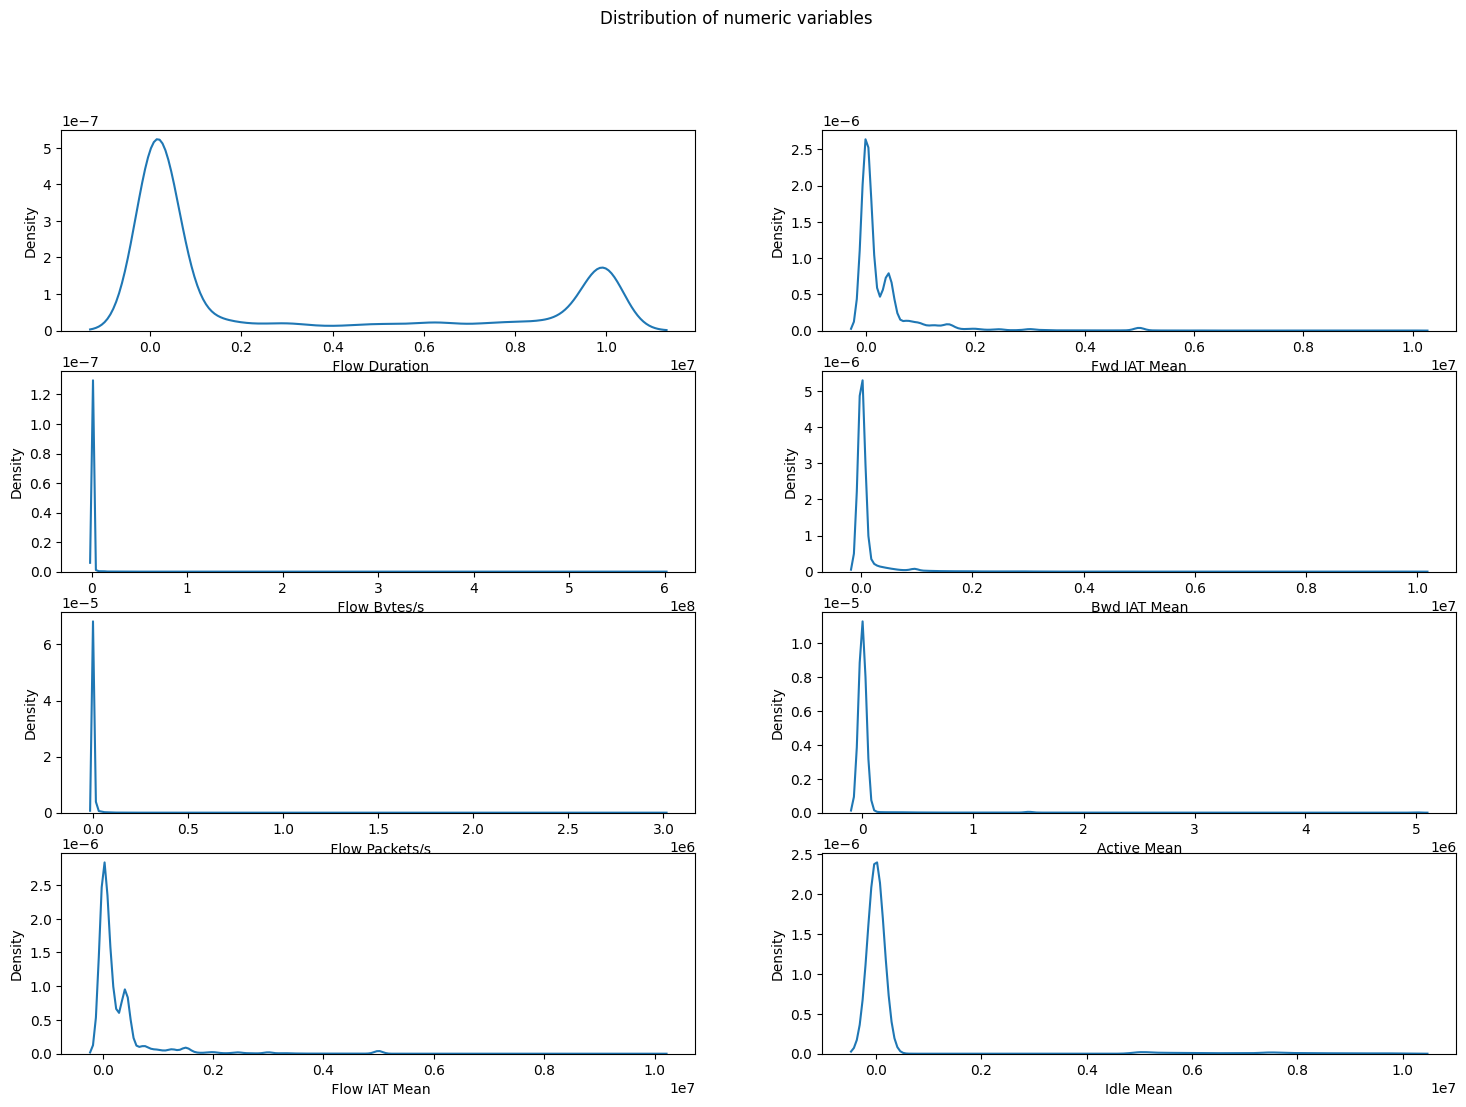

In [ ]:
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(18, 12))

sns.kdeplot(ax=ax[0,0], x=df[' Flow Duration'])
sns.kdeplot(ax=ax[1,0], x=df[' Flow Bytes/s'])
sns.kdeplot(ax=ax[2,0], x=df[' Flow Packets/s'])
sns.kdeplot(ax=ax[3,0], x=df[' Flow IAT Mean'])
sns.kdeplot(ax=ax[0, 1], x=df['Fwd IAT Mean'])
sns.kdeplot(ax=ax[1, 1], x=df['Bwd IAT Mean'])
sns.kdeplot(ax=ax[2, 1], x=df['Active Mean'])
sns.kdeplot(ax=ax[3, 1], x=df['Idle Mean'])

fig.suptitle("Distribution of numeric variables")
plt.savefig('scenarioA_num_variables.png', bbox_inches='tight')

### Correlation measure of the features

In [ ]:
df.corr()

<ipython-input-26-2f6f6606aa2c>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr()


,Source IP,Source Port,Destination IP,Destination Port,Protocol,Flow Duration,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,...,Bwd IAT Max,Bwd IAT Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
Source IP,1.000000,-0.021725,0.112526,0.054470,-0.044704,0.063013,0.006437,-0.008962,0.064939,0.001830,...,0.012487,-0.002702,0.036805,NaN,0.036805,0.036805,0.007740,NaN,0.007740,0.007740
Source Port,-0.021725,1.000000,-0.326295,-0.315625,0.035942,-0.217805,-0.024103,-0.050263,-0.064185,-0.128674,...,0.026296,0.002482,-0.026484,NaN,-0.026484,-0.026484,-0.024318,NaN,-0.024318,-0.024318
Destination IP,0.112526,-0.326295,1.000000,0.070220,-0.060642,0.149116,0.021011,0.026461,0.063277,0.094765,...,0.036323,0.003853,0.069742,NaN,0.069742,0.069742,0.073555,NaN,0.073555,0.073555
Destination Port,0.054470,-0.315625,0.070220,1.000000,-0.075504,0.281914,0.003697,0.048360,0.017074,0.021416,...,0.061820,0.077420,0.014750,NaN,0.014750,0.014750,-0.000233,NaN,-0.000233,-0.000233
Protocol,-0.044704,0.035942,-0.060642,-0.075504,1.000000,-0.245634,-0.002620,-0.040510,0.176793,-0.089243,...,-0.303797,-0.031931,-0.018927,NaN,-0.018927,-0.018927,-0.088057,NaN,-0.088057,-0.088057
Flow Duration,0.063013,-0.217805,0.149116,0.281914,-0.245634,1.000000,-0.019669,-0.047145,0.208470,0.365712,...,0.418175,0.103092,0.192196,NaN,0.192196,0.192196,0.303071,NaN,0.303071,0.303071
Flow Bytes/s,0.006437,-0.024103,0.021011,0.003697,-0.002620,-0.019669,1.000000,0.652822,-0.020304,-0.015316,...,-0.010133,-0.004765,-0.005323,NaN,-0.005323,-0.005323,-0.008398,NaN,-0.008398,-0.008398
Flow Packets/s,-0.008962,-0.050263,0.026461,0.048360,-0.040510,-0.047145,0.652822,1.000000,-0.030070,-0.022947,...,-0.022057,-0.007034,-0.008197,NaN,-0.008197,-0.008197,-0.014101,NaN,-0.014101,-0.014101
Flow IAT Mean,0.064939,-0.064185,0.063277,0.017074,0.176793,0.208470,-0.020304,-0.030070,1.000000,0.527310,...,0.072677,0.202057,0.253241,NaN,0.253241,0.253241,0.377036,NaN,0.377036,0.377036
Flow IAT Std,0.001830,-0.128674,0.094765,0.021416,-0.089243,0.365712,-0.015316,-0.022947,0.527310,1.000000,...,0.476821,0.398643,0.231189,NaN,0.231189,0.231189,0.613219,NaN,0.613219,0.613219


Thus, we print the correlation heatmap as follows.

<ipython-input-27-8601fab7896e>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(),annot = True, cmap="Spectral", center = 0)


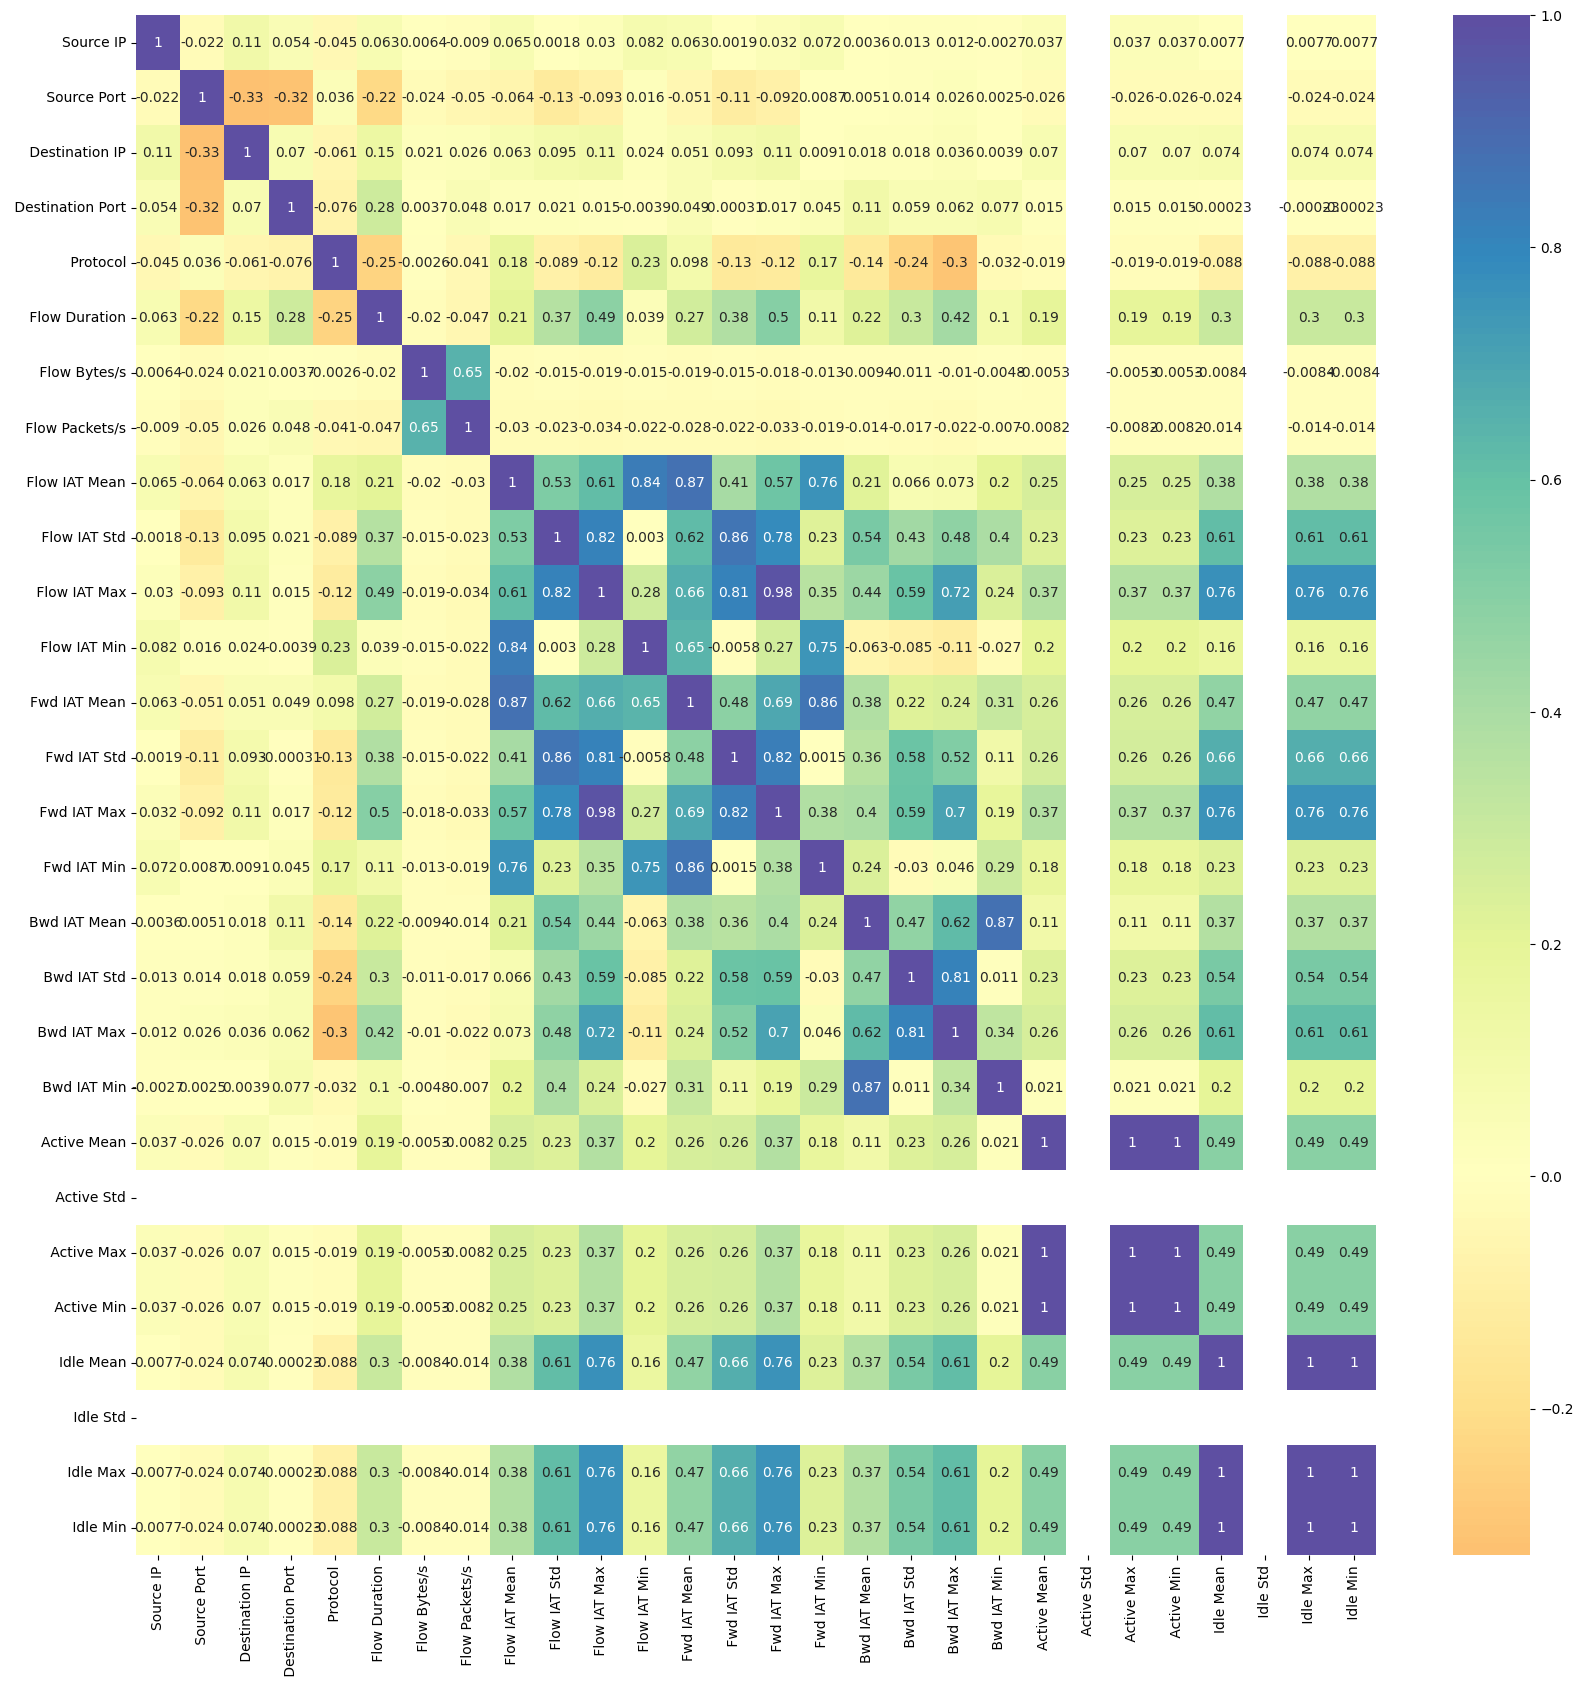

In [ ]:
fig = plt.figure(figsize = [20,20])
sns.heatmap(df.corr(),annot = True, cmap="Spectral", center = 0)
plt.show()

### Box plots

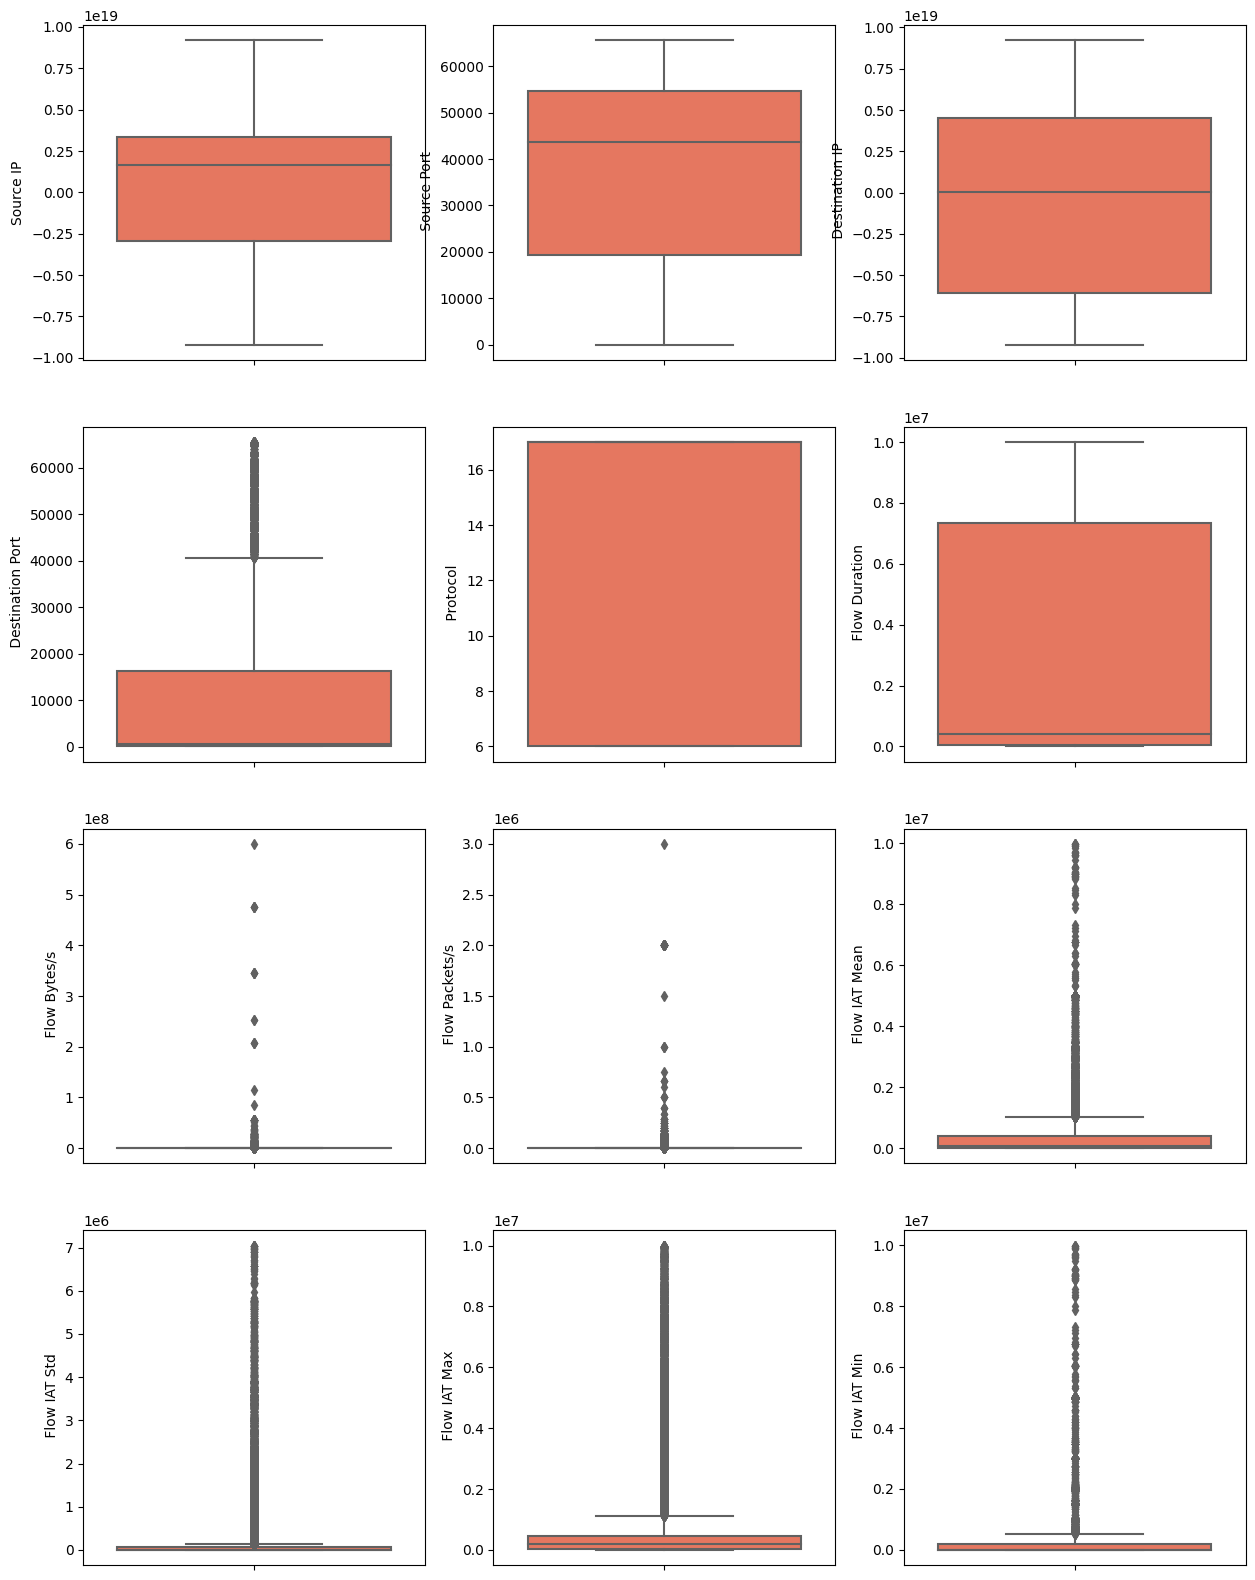

In [ ]:
fig = plt.figure(figsize = [15,20])
cols = list(df.columns.values)
cnt = 1
for col in cols :
    if cnt > 12:
        break

    plt.subplot(4,3,cnt)
    sns.boxplot(data = df, y = col, palette = 'Reds')
    cnt+=1
plt.show()

### Count plot to compare the frequency of the target classes
We plot a bar chart in order to compare the number of '*TOR*' samples as compared to the number of '*nonTOR*' samples.


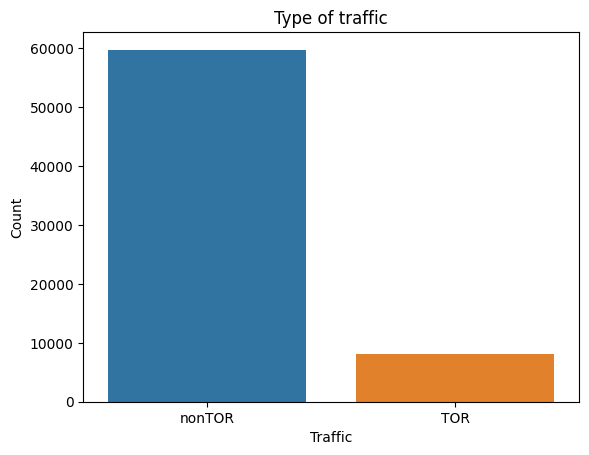

In [ ]:
g = sns.countplot(x=df['label'])
g.set(title='Type of traffic', ylabel='Count', xlabel='Traffic');
plt.savefig('type_of_traffic.png', bbox_inches='tight')

In [ ]:
# Finding the class imbalance ratio
class_counts = df['label'].value_counts()
imbalance_ratio = class_counts.min() / class_counts.max()

print("Class Counts:")
print(class_counts)
print("Imbalance Ratio: {:.2f}".format(imbalance_ratio))

Class Counts:
nonTOR    59784
TOR        8044
Name: label, dtype: int64
Imbalance Ratio: 0.13


Therefore, we find that there is a high imbalance in the two target classes of the dataset, which implies an **imbalanced learning problem**.













# Feature Engineering

In [ ]:
df = missing_delete(data)
df = conv_obj_float(df)

### Encoding the target variable

In [ ]:
df['label'].unique()

array(['nonTOR', 'TOR'], dtype=object)

In [ ]:
df['label'] = df['label'].map({'TOR': 1, 'nonTOR': 0})

In [ ]:
df['label'].unique()

array([0, 1])

In [ ]:
df

,Source IP,Source Port,Destination IP,Destination Port,Protocol,Flow Duration,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,...,Bwd IAT Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,label
0,2.837506e+17,53913,4.095149e+16,80,6,435,0.0,4.597701e+03,435.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,2.837506e+17,53913,4.095149e+16,80,6,259,0.0,7.722008e+03,259.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,2.837506e+17,53913,4.095149e+16,80,6,891,0.0,2.244669e+03,891.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,2.837506e+17,53913,4.095149e+16,80,6,1074,0.0,1.862197e+03,1074.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,2.837506e+17,53913,4.095149e+16,80,6,315,0.0,6.349206e+03,315.0,0.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67823,-2.095680e+18,138,9.350604e+17,138,17,1,475000000.0,2.000000e+06,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0
67824,-2.095680e+18,138,9.350604e+17,138,17,1,475000000.0,2.000000e+06,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0
67825,-2.095680e+18,138,9.350604e+17,138,17,1,475000000.0,2.000000e+06,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0
67826,-2.095680e+18,138,9.350604e+17,138,17,1,475000000.0,2.000000e+06,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0


### Splitting dataset into train set and test set

In [ ]:
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

In [ ]:
def split_dataset(df):
  X = df.iloc[:, :-1]
  y = df.iloc[:, -1]
  1X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)
  return X_train, X_test, y_train, y_test

In [ ]:
X_train, X_test, y_train, y_test = split_dataset(df)

In [ ]:
y_train

51238    0
35277    0
64449    0
30647    1
51178    1
        ..
37194    0
6265     0
54886    1
860      0
15795    0
Name: label, Length: 54262, dtype: int64

###  Handling imbalanced data

 We will implement the following techniques to solve the issue of imbalanced data :-
*   **Synthetic Minority Oversampling (SMOTE):** SMOTE is an oversampling technique where the synthetic samples are generated for the minority class. This algorithm helps to overcome the overfitting problem posed by random oversampling. It focuses on the feature space to generate new instances with the help of interpolation between the positive instances that lie together.

*   **Oversampling:** Oversampling can be defined as adding more copies to the minority class. Oversampling can be a good choice when you don’t have a ton of data to work with.

*   **Undersampling:** Undersampling can be defined as removing some observations of the majority class. This is done until the majority and minority class is balanced out.

#### SMOTE

In [ ]:
def smote(X_train, y_train):
    smote = SMOTE(sampling_strategy='auto', random_state=42)
    X_train, y_train = smote.fit_resample(X_train, y_train)
    return X_train, y_train

In [ ]:
# Checking if smote function works
X_train_bal1, y_train_bal1 = smote(X_train, y_train)
class_counts = np.unique(y_train_bal1, return_counts=True)
print(class_counts)

(array([0, 1]), array([47820, 47820]))


#### Oversampling

In [ ]:
def oversampler(X_train, y_train):
    ros = RandomOverSampler(random_state=42)
    X_train, y_train = ros.fit_resample(X_train, y_train)
    return X_train, y_train

In [ ]:
# Checking if oversampler function works
X_train_bal2, y_train_bal2 = oversampler(X_train, y_train)
class_counts = np.unique(y_train_bal2, return_counts=True)
print(class_counts)

(array([0, 1]), array([47820, 47820]))


#### Undersampling

In [ ]:
def undersampler(X_train, y_train):
    rus = RandomUnderSampler(random_state=42)
    X_train, y_train = rus.fit_resample(X_train, y_train)
    return X_train, y_train

In [ ]:
# Checking if undersampler function works
X_train_binary_bal3, y_train_binary_bal3 = undersampler(X_train, y_train)
class_counts = np.unique(y_train_binary_bal3, return_counts=True)
print(class_counts)

(array([0, 1]), array([6442, 6442]))


#### No balancing

In [ ]:
def no_balancing(X_train, y_train):
    return X_train, y_train

In [ ]:
X_train_binary_no_bal, y_train_binary_no_bal = no_balancing(X_train, y_train)
class_counts = np.unique(y_train_binary_no_bal, return_counts=True)
print(class_counts)

(array([0, 1]), array([47820,  6442]))


### Standardizing features

In [ ]:
def standardization(X_train, X_test):
    from sklearn.preprocessing import StandardScaler

    # Standardize the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    return X_train_scaled, X_test_scaled

In [ ]:
X_train, X_test, y_train, y_test = split_dataset(df)

In [ ]:
X_train_bal1, y_train_bal1 = smote(X_train, y_train)
class_counts = np.unique(y_train_bal1, return_counts=True)
print(class_counts)

(array([0, 1]), array([47820, 47820]))


In [ ]:
X_train_scaled, X_test_scaled = standardization(X_train_bal1, X_test)

### Feature Selection

#### Tree-based Feature Selection

Tree-based estimator can be used to compute impurity-based feature importances to discard irrelevant features (when coupled with the SelectFromModel meta-transformer)

In [ ]:
def tree_feature_selection(X, data, X_train, y_train, X_test, feature_names):
    from sklearn.ensemble import ExtraTreesClassifier
    from sklearn.datasets import load_iris
    from sklearn.feature_selection import SelectFromModel

    clf = ExtraTreesClassifier(n_estimators=50)
    clf.fit(X_train, y_train)
    model = SelectFromModel(clf, prefit=True)
    X_train = model.transform(X_train)
    X_test = model.transform(X_test)
    selected_feature_indices = model.get_support(indices=True)
    selected_features = [feature_names[i] for i in selected_feature_indices]
    return X_train, X_test, selected_features

In [ ]:
X_train_selected, X_test_selected, selected_features = tree_feature_selection(X, df, X_train_scaled, y_train_bal1, X_test_scaled, feature_names)
print(selected_features)

['Source IP', ' Source Port', ' Destination IP', ' Destination Port', ' Protocol', ' Flow Duration']


#### Correlation-based feature selection

In [ ]:
def corr(X, data, X_train, y_train, X_test, feature_names):
    target_correlation = X.corr().iloc[-1].abs().sort_values(ascending=False)
    threshold = 0.5
    selected_features = target_correlation[target_correlation.abs() > threshold].index

    # Get the indices of selected features
    selected_feature_indices = [data.columns.get_loc(feature) for feature in selected_features]

    # Select features using indices
    X_train_selected = X_train[:, selected_feature_indices]
    X_test_selected = X_test[:, selected_feature_indices]

    return X_train, X_test, selected_features

In [ ]:
X_train_binary_corr, X_test_binary_corr, selected_features_binary_corr = corr(X, df, X_train_scaled, y_train_bal1, X_test_scaled, feature_names)
print(selected_features_binary_corr)

Index([' Idle Min', ' Idle Max', 'Idle Mean', ' Flow IAT Max', ' Fwd IAT Max',
       ' Fwd IAT Std', ' Flow IAT Std', ' Bwd IAT Max', ' Bwd IAT Std'],
      dtype='object')


# Hyperparameter tuning using Grid Search Cross Validation

In [ ]:
from sklearn.model_selection import GridSearchCV

def HyperP_tuning(model, HyperParameters, X_train, y_train):
    grid_search = GridSearchCV(estimator=model, param_grid=HyperParameters, cv=5, scoring='f1', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    best_params = grid_search.best_params_
    best_model = grid_search.best_estimator_
    return best_model, best_params

# Main function
---

It will do all trainig, and prediction in a single function called main. This approach makes us able to be more efficient and do the DRY principle which stands for "Don't Repeat Yourself!"

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

def main(dataset, X_train, X_test, y_train, y_test, model, feature_names, standardization, feature_selection, balancing, HyperParameters, HyperP_tuning ):

    # Handling the imbalanced data
    X_train, y_train = balancing(X_train, y_train)

    # Scaling the features
    X_train, X_test = standardization(X_train, X_test)

    # Feature selection
    X_train, X_test, selected_features = feature_selection(X, dataset, X_train, y_train, X_test, feature_names)

    # Hyperparameter tuning
    best_model, best_params = HyperP_tuning(model, HyperParameters, X_train, y_train)

    # Predicting the test dataset
    y_pred = best_model.predict(X_test)


    # # Generating a classification report
    # binary_report = classification_report(y_test, y_pred)

    # # Confusion matrix
    # cm = confusion_matrix(y_test, y_pred, labels = best_model.classes_)
    # disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
    # disp.plot()
    # plt.show()

    f1_score_weighted= f1_score(y_test, y_pred, average='weighted')
    precision_weighted= precision_score(y_test, y_pred, average='weighted')
    recall_weighted= recall_score(y_test, y_pred, average='weighted')


    return best_model, best_params, selected_features, f1_score_weighted, precision_weighted, recall_weighted, y_pred

### Implementing the stratified K-fold cross validation

Using Stratified cross-validation for splitting dataset to train set and test set with 5 splits, instead of normal splitting.

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
def main_with_crossval(dataset, model, feature_names, missing_delete, conv_obj_float, main_func, replace_inf, standardization, feature_selection, balancing, HyperP_tuning, HyperParameters
    # dataset, missing_delete,
    # cat_conv,
    # main_func,
    # model, label_index,
    # X_y_creation,infinite_value_drop, converting_func,
    # HyperParameters
    ):

    # Replace the infinite values in the datset with NaN
    dataset = replace_inf(dataset)

    # Drop the NaN values from the dataset
    dataset = missing_delete(dataset)

    # Convert categorical data to numeric
    dataset = conv_obj_float(dataset)

    X = dataset.iloc[:, :-1]
    y = dataset.iloc[:, -1]

    skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
    f1_scores = []
    precisions = []
    recalls = []
    X = X.values
    y = y.values
    predictions = []
    for i, (train_index, test_index) in enumerate(skf.split(X,y)):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        model, best_params, selected_features,  f1_score_weighted, precision_weighted, recall_weighted, y_pred = main(dataset, X_train, X_test, y_train, y_test, model,
                                                                                                  feature_names=feature_names,
                                                                                                  standardization=standardization,
                                                                                                  feature_selection=feature_selection,
                                                                                                  balancing=smote,
                                                                                                  HyperParameters= HyperParameters,
                                                                                                  HyperP_tuning = HyperP_tuning)
        f1_scores.append(f1_score_weighted)
        precisions.append(precision_weighted)
        recalls.append(recall_weighted)
        predictions=y_pred


    # Calculating the mean of the scores of all the iterations of K-fold cross_val
    f1_avg = np.mean(f1_scores)
    precision_avg = np.mean(precisions)
    recall_avg = np.mean(recalls)

  # Confusion matrix
    cm = confusion_matrix(y_test, predictions, labels = model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot()
    plt.show()


    return f1_avg, precision_avg, recall_avg, model, selected_features, best_params

# Data Modelling

### Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators = 100, criterion = 'entropy', random_state = 0)

In [ ]:
parameters_rf =  {
    'n_estimators': [10,100, 200], 
    'max_depth': [10,20, 30], 
    'min_samples_split': [2,5,10]
}

Tree-based feature selection

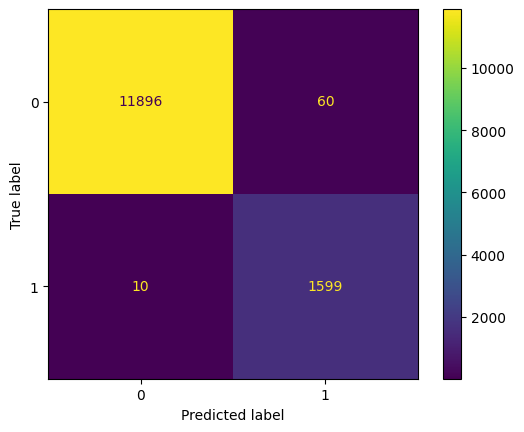

Binary F1 Average (rf): 0.9951034840709964
Binary Precision Average (rf): 0.9952199853868882
Binary Recall Average (rf): 0.9950610747723149
Selected Features: ['Source IP', ' Destination IP', ' Destination Port', ' Protocol', ' Flow Duration', 'Idle Mean', ' Idle Max', ' Idle Min']
Binary best Parameters for rf: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 10}


In [ ]:
binary_f1_avg_rf, binary_precision_avg_rf,binary_recall_avg_rf,binary_model_rf, selected_features,binary_best_params_rf = main_with_crossval(dataset = data,
                                                  model=rf,
                                                  feature_names=feature_names,
                                                  missing_delete=missing_delete,
                                                  conv_obj_float=conv_obj_float,
                                                    main_func = main,
                                                  replace_inf=replace_inf,
                                                  standardization=standardization,
                                                  feature_selection=tree_feature_selection,
                                                  balancing=smote,
                                                  HyperP_tuning=HyperP_tuning,
                                                  HyperParameters=parameters_rf)


print(f"Binary F1 Average (rf): {binary_f1_avg_rf}")
print(f"Binary Precision Average (rf): {binary_precision_avg_rf}")
print(f"Binary Recall Average (rf): {binary_recall_avg_rf}")
print(f"Selected Features: {selected_features}")
print(f"Binary best Parameters for rf: {binary_best_params_rf}")

Correlation-based feature selection

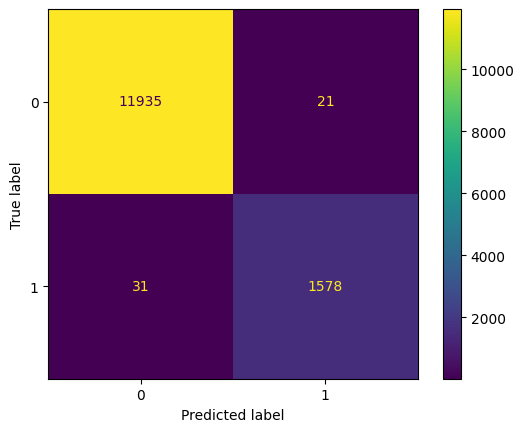

Binary F1 Average (rf): 0.9962207764546402
Binary Precision Average (rf): 0.9962229075486517
Binary Recall Average (rf): 0.9962257598637647
Selected Features: Index([' Idle Min', ' Idle Max', 'Idle Mean', ' Flow IAT Max', ' Fwd IAT Max',
       ' Fwd IAT Std', ' Flow IAT Std', ' Bwd IAT Max', ' Bwd IAT Std'],
      dtype='object')
Binary best Parameters for rf: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 10}


In [ ]:
binary_f1_avg_rf, binary_precision_avg_rf,binary_recall_avg_rf,binary_model_rf, selected_features,binary_best_params_rf = main_with_crossval(dataset = data,
                                                  model=rf,
                                                  feature_names=feature_names,
                                                  missing_delete=missing_delete,
                                                  conv_obj_float=conv_obj_float,
                                                    main_func = main,
                                                  replace_inf=replace_inf,
                                                  standardization=standardization,
                                                  feature_selection=corr,
                                                  balancing=smote,
                                                  HyperP_tuning=HyperP_tuning,
                                                  HyperParameters=parameters_rf)


print(f"Binary F1 Average (rf): {binary_f1_avg_rf}")
print(f"Binary Precision Average (rf): {binary_precision_avg_rf}")
print(f"Binary Recall Average (rf): {binary_recall_avg_rf}")
print(f"Selected Features: {selected_features}")
print(f"Binary best Parameters for rf: {binary_best_params_rf}")



### Logistic Regression Classifier

In [ ]:
from sklearn.linear_model import LogisticRegression
log = LogisticRegression()

In [ ]:
log_parameters =  {
    'penalty': ['none', 'l2'],
    'C': [0.1,0.01, 0.1, 1, 10, 100],
    'solver': ['newton-cg','lbfgs', 'liblinear']
}

Tree-based feature selection

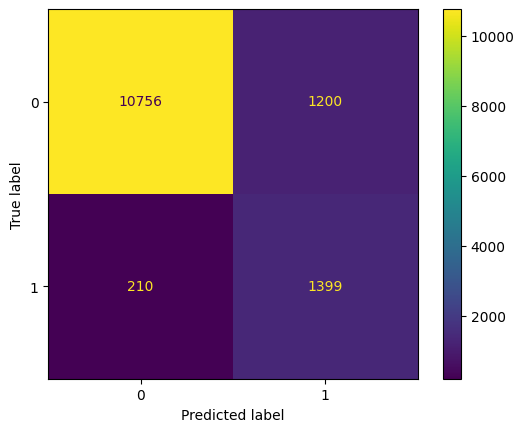

Binary F1 Average (log): 0.9084822581396136
Binary Precision Average (log): 0.9279168020580851
Binary Recall Average (log): 0.8994956679006986
Selected Features: ['Source IP', ' Source Port', ' Destination IP', ' Destination Port', ' Protocol', ' Flow Duration', ' Fwd IAT Std', ' Bwd IAT Max', ' Idle Max']
Binary best Parameters for log: {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}


In [ ]:
binary_f1_avg_log, binary_precision_avg_log,binary_recall_avg_log,binary_model_log, selected_features,binary_best_params_log = main_with_crossval(dataset = data,
                                                  model=log,
                                                  feature_names=feature_names,
                                                  missing_delete=missing_delete,
                                                  conv_obj_float=conv_obj_float,
                                                    main_func = main,
                                                  replace_inf=replace_inf,
                                                  standardization=standardization,
                                                  feature_selection=tree_feature_selection,
                                                  balancing=smote,
                                                  HyperP_tuning=HyperP_tuning,
                                                  HyperParameters=log_parameters)


print(f"Binary F1 Average (log): {binary_f1_avg_log}")
print(f"Binary Precision Average (log): {binary_precision_avg_log}")
print(f"Binary Recall Average (log): {binary_recall_avg_log}")
print(f"Selected Features: {selected_features}")
print(f"Binary best Parameters for log: {binary_best_params_log}")

Correlation-based feature selection

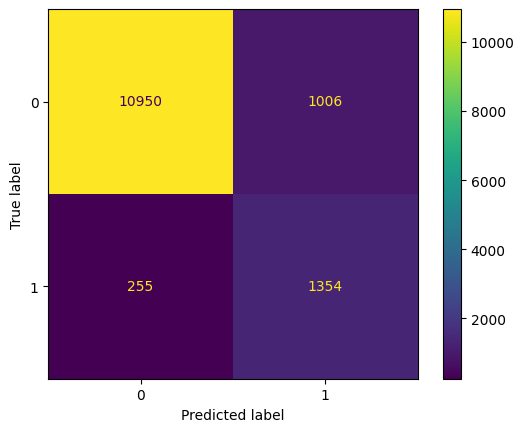

Binary F1 Average (log): 0.912320372093658
Binary Precision Average (log): 0.9272794155485371
Binary Recall Average (log): 0.9049212317670001
Selected Features: Index([' Idle Min', ' Idle Max', 'Idle Mean', ' Flow IAT Max', ' Fwd IAT Max',
       ' Fwd IAT Std', ' Flow IAT Std', ' Bwd IAT Max', ' Bwd IAT Std'],
      dtype='object')
Binary best Parameters for log: {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}


In [ ]:
binary_f1_avg_log, binary_precision_avg_log,binary_recall_avg_log,binary_model_log, selected_features,binary_best_params_log = main_with_crossval(dataset = data,
                                                  model=log,
                                                  feature_names=feature_names,
                                                  missing_delete=missing_delete,
                                                  conv_obj_float=conv_obj_float,
                                                    main_func = main,
                                                  replace_inf=replace_inf,
                                                  standardization=standardization,
                                                  feature_selection=corr,
                                                  balancing=smote,
                                                  HyperP_tuning=HyperP_tuning,
                                                  HyperParameters=log_parameters)


print(f"Binary F1 Average (log): {binary_f1_avg_log}")
print(f"Binary Precision Average (log): {binary_precision_avg_log}")
print(f"Binary Recall Average (log): {binary_recall_avg_log}")
print(f"Selected Features: {selected_features}")
print(f"Binary best Parameters for log: {binary_best_params_log}")



### Bagged Logistic Regression(Bootstrap Aggregating)

In [ ]:
from sklearn.ensemble import BaggingClassifier
base_model = log
bag = BaggingClassifier(base_model, random_state=42)
bag_parameters = {
    'n_estimators': [5, 10, 20, 30]
}

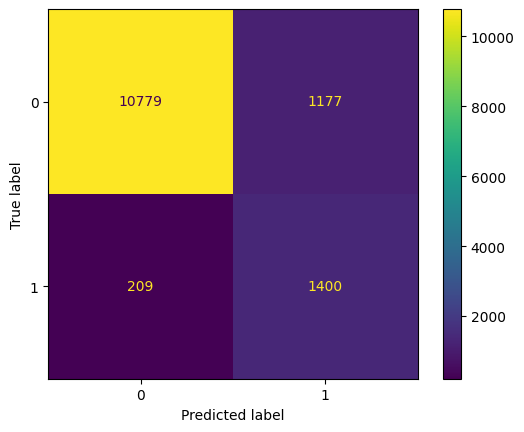

Binary F1 Average (bag): 0.9070121200468615
Binary Precision Average (bag): 0.9274830177821693
Binary Recall Average (bag): 0.897608632061279
Selected Features: ['Source IP', ' Source Port', ' Destination IP', ' Destination Port', ' Protocol', ' Flow Duration', ' Flow IAT Max', ' Idle Min']
Binary best Parameters for bag: {'n_estimators': 5}


In [ ]:
binary_f1_avg_bag, binary_precision_avg_bag,binary_recall_avg_bag,binary_model_bag, selected_features,binary_best_params_bag = main_with_crossval(dataset = data,
                                                  model=bag,
                                                  feature_names=feature_names,
                                                  missing_delete=missing_delete,
                                                  conv_obj_float=conv_obj_float,
                                                    main_func = main,
                                                  replace_inf=replace_inf,
                                                  standardization=standardization,
                                                  feature_selection=tree_feature_selection,
                                                  balancing=smote,
                                                  HyperP_tuning=HyperP_tuning,
                                                  HyperParameters=bag_parameters)


print(f"Binary F1 Average (bag): {binary_f1_avg_bag}")
print(f"Binary Precision Average (bag): {binary_precision_avg_bag}")
print(f"Binary Recall Average (bag): {binary_recall_avg_bag}")
print(f"Selected Features: {selected_features}")
print(f"Binary best Parameters for bag: {binary_best_params_bag}")

# Comparing models

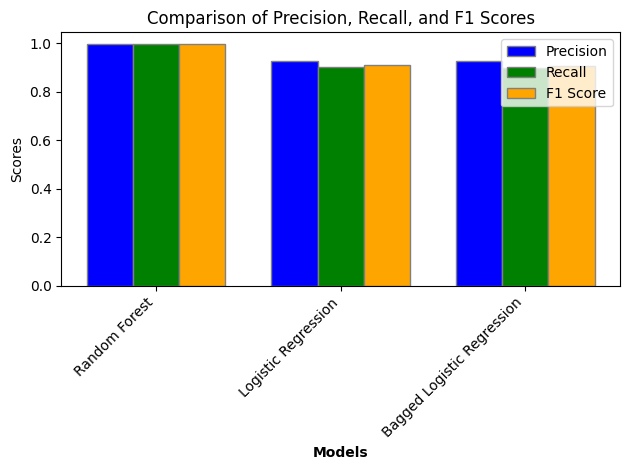

In [ ]:
f1_scores = [binary_f1_avg_rf, binary_f1_avg_log, binary_f1_avg_bag]
precision_scores = [binary_precision_avg_rf, binary_precision_avg_log, binary_precision_avg_bag]
recall_scores = [binary_recall_avg_rf, binary_recall_avg_log, binary_recall_avg_bag]
labels = ['Random Forest', 'Logistic Regression', 'Bagged Logistic Regression']

# Bar width
bar_width = 0.25

# Set up positions for the bars
r1 = np.arange(len(labels))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

# Plotting the grouped bar plot
plt.bar(r1, precision_scores, color='blue', width=bar_width, edgecolor='grey', label='Precision')
plt.bar(r2, recall_scores, color='green', width=bar_width, edgecolor='grey', label='Recall')
plt.bar(r3, f1_scores, color='orange', width=bar_width, edgecolor='grey', label='F1 Score')

# Adding labels and title
plt.xlabel('Models', fontweight='bold')
plt.xticks([r + bar_width for r in range(len(labels))], labels)
plt.ylabel('Scores')
plt.title('Comparison of Precision, Recall, and F1 Scores')
plt.legend()
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Display the plot
plt.show()